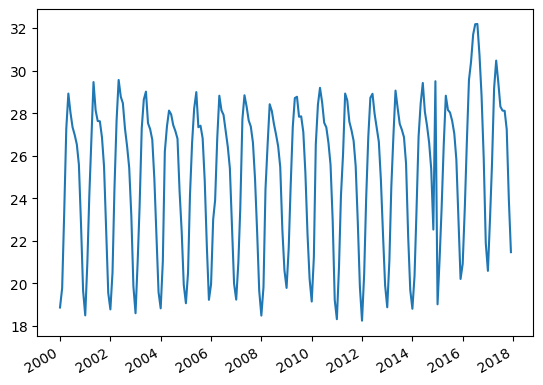

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter
from matplotlib import dates as mpld

temp_df = pd.read_csv('dataset/average_temp_india.csv')
temp_df['date'] = pd.to_datetime(temp_df['date'])
temp_df = temp_df.set_index('date')

# 앞의 70% 데이터만 학습에 사용
train_df = temp_df.iloc[:int(len(temp_df)*0.7)]
test_df = temp_df.iloc[int(len(temp_df)*0.7):]

plt.plot(temp_df['values'])
plt.gcf().autofmt_xdate()
plt.show()

#### 2016년 이후 이상치로 보이는 게 있음

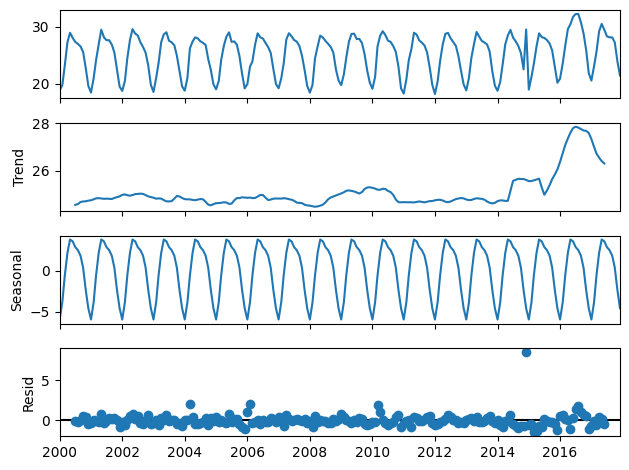

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(temp_df,model='additive',period=12).plot()
plt.show()

c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


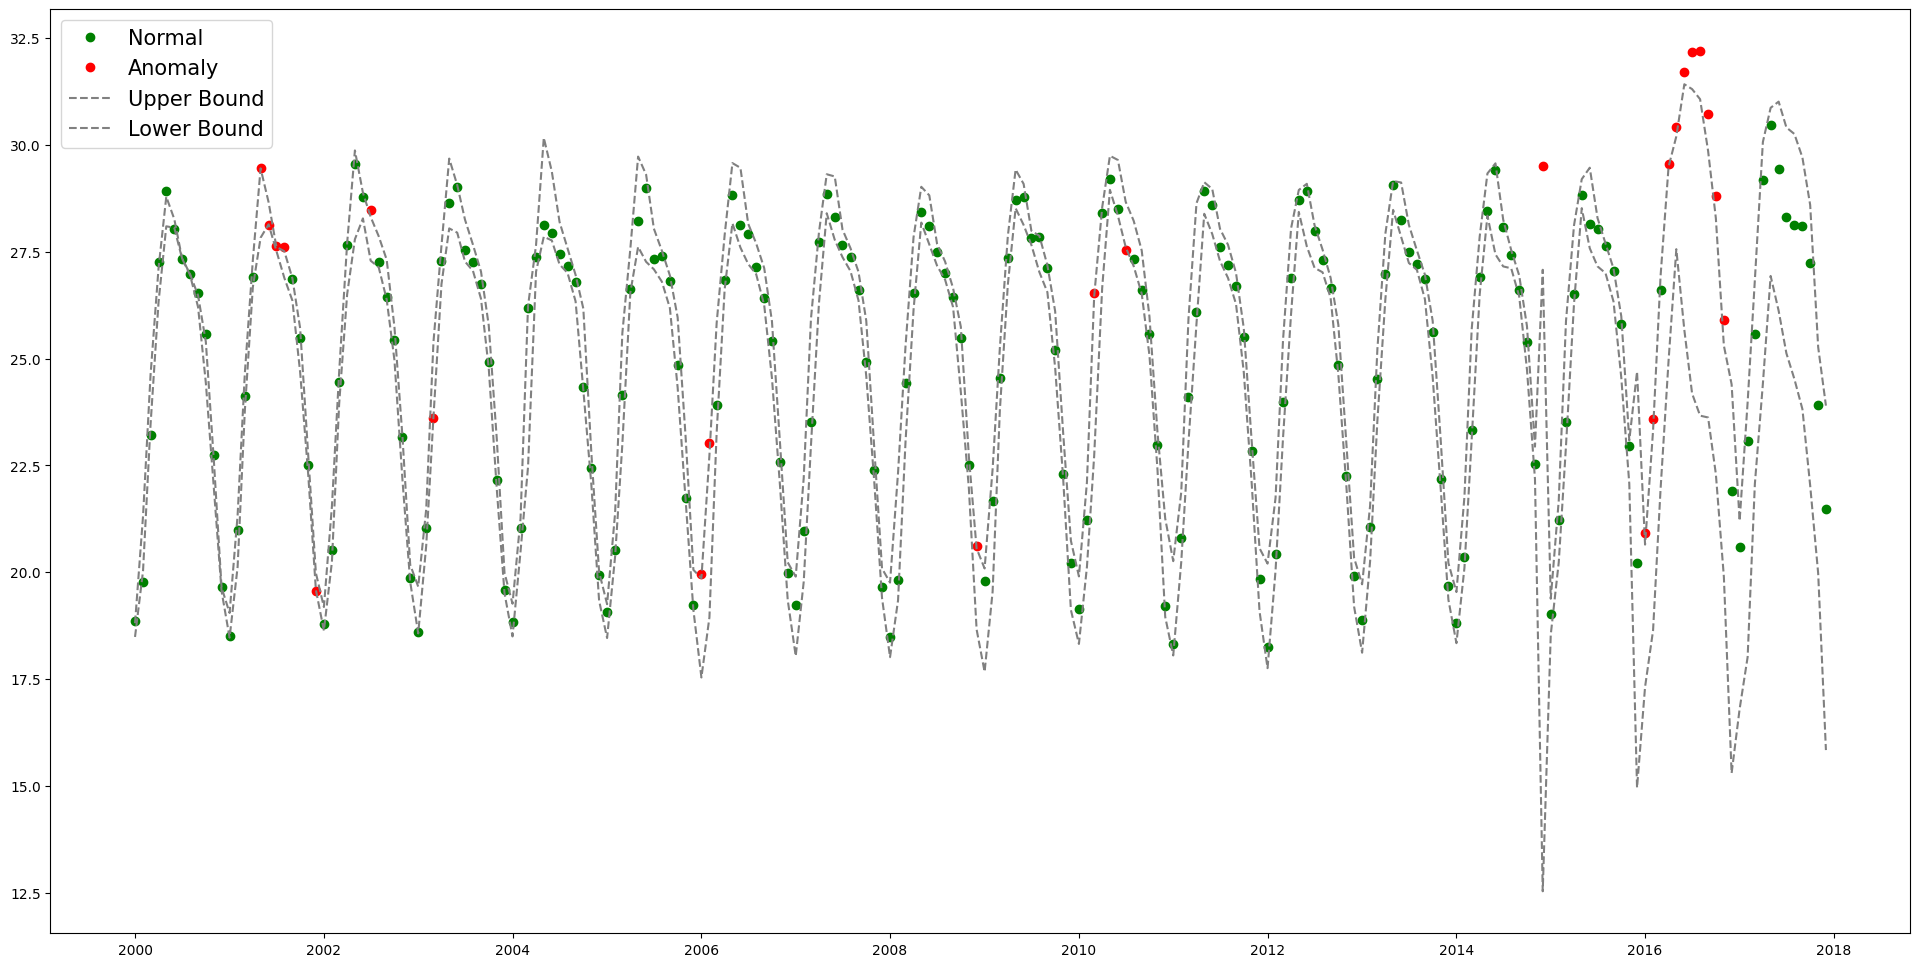

In [5]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ES 모델을 만들어 학습하고 전체 데이터에 대해 예측한다.
# additive는 경향성이 일정함을 의미하고, 경향성 변동폭이 있을 때는 multiplicative를 사용
model = ExponentialSmoothing(
    train_df, trend='additive', seasonal='additive').fit()
    
prediction = model.predict(
    start=temp_df.index[0], end=temp_df.index[-1])

"""Brutlag Algorithm"""
PERIOD = 12        # The given time series has seasonal_period=12
GAMMA = 0.3684211  # the seasonility component
SF = 1.96          # brutlag scaling factor for the confidence bands.
UB = []            # upper bound or upper confidence band
LB = []            # lower bound or lower confidence band

# 실측치와 예측치를 비교하는 자료구조
difference_array = []
dt = []
difference_table = {"actual": temp_df, "predicted": prediction, "difference": difference_array, "UB": UB, "LB": LB}

# brutlag 알고리즘
# 12개월 이전의 실측/결측 차이에 0.63, 이번달 차이에 0.37 정도의 가중치를 주어 저장
for i in range(len(prediction)):
    diff = temp_df.iloc[i]-prediction.iloc[i]
    if i < PERIOD:
        dt.append(GAMMA*abs(diff))
    else:
        dt.append(GAMMA*abs(diff) + (1-GAMMA)*dt[i-PERIOD])

# 저장된 실측/결측 차이를 예측치의 95% 신뢰구간(1.96)으로 반영하여 Upper/Lower Band 계산
    difference_array.append(diff)
    UB.append(prediction[i]+SF*dt[i])
    LB.append(prediction[i]-SF*dt[i])
    
"""Classification of data points as either normal or anomaly"""
normal = []
normal_date = []
anomaly = []
anomaly_date = []

# 신뢰구간을 벗어나는지 판단하여 normal, anomaly 결정
for i in range(len(temp_df.index)):
    if ((UB[i] <= temp_df.iloc[i]).bool() or (LB[i] >= temp_df.iloc[i]).bool()) and i > PERIOD:
        anomaly_date.append(temp_df.index[i])
        anomaly.append(temp_df.iloc[i][0])
    else:
        normal_date.append(temp_df.index[i])
        normal.append(temp_df.iloc[i][0])
        
anomaly = pd.DataFrame({"date": anomaly_date, "value": anomaly})
anomaly.set_index('date', inplace=True)
normal = pd.DataFrame({"date": normal_date, "value": normal})
normal.set_index('date', inplace=True)

# plotting
plt.figure(figsize=(24,12))
plt.plot(normal.index, normal, 'o', color='green')
plt.plot(anomaly.index, anomaly, 'o', color='red')
plt.plot(temp_df.index, UB, linestyle='--', color='grey')
plt.plot(temp_df.index, LB, linestyle='--', color='grey')
plt.legend(['Normal', 'Anomaly', 'Upper Bound', 'Lower Bound'],fontsize=15)
plt.show()